In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json


In [2]:
import json

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

#load the data
training_solutions = load_json('/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json')
evaluation_solutions = load_json('/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json')
training_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json')
evaluation_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json')
test_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json')
sample_submission = load_json('/kaggle/input/arc-prize-2024/sample_submission.json')

In [3]:
def inspect_data(data, num_samples=1):
    for key, value in list(data.items())[:num_samples]:
        print(f"Key: {key}")
        print(f"Sample Data: {value}\n")
        
print("Training Solutions:")
inspect_data(training_solutions)

print("Training Challenges:")
inspect_data(training_challenges)

print("Evaluation Solutions:")
inspect_data(evaluation_solutions)

print("Evaluation Challenges:")
inspect_data(evaluation_challenges)

print("Test Challenges:")
inspect_data(test_challenges)

print("Sample submission:")
inspect_data(sample_submission)

Training Solutions:
Key: 007bbfb7
Sample Data: [[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 7, 0, 7, 7, 0, 0, 0, 0]]]

Training Challenges:
Key: 007bbfb7
Sample Data: {'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]]}], 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0,

In [4]:
sample_key = list(training_solutions.keys())[0]
print(f"Sample Key: {sample_key}")
print("Sample Data:", training_solutions[sample_key])

Sample Key: 007bbfb7
Sample Data: [[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 7, 0, 7, 7, 0, 0, 0, 0]]]


In [5]:
#compute the mean, standard deviation, minimum, and maximum values of the data
sample_data = training_solutions[sample_key]
#convert to numpy array
data_array = np.array(sample_data)

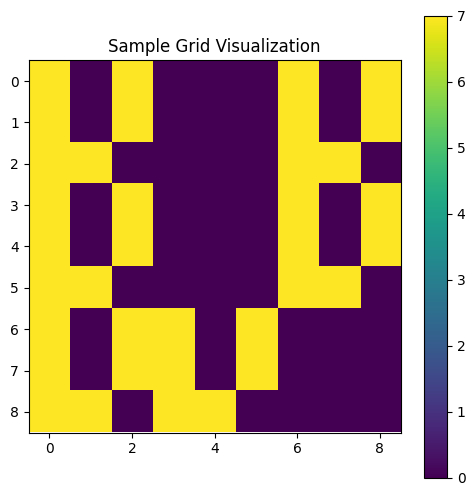

Grid Summary:
Mean Value: 3.11
Standard Deviation: 3.48
Minimum Value: 0
Maximum Value: 7

Frequency Distribution:
Value 0: 45 occurrences
Value 7: 36 occurrences


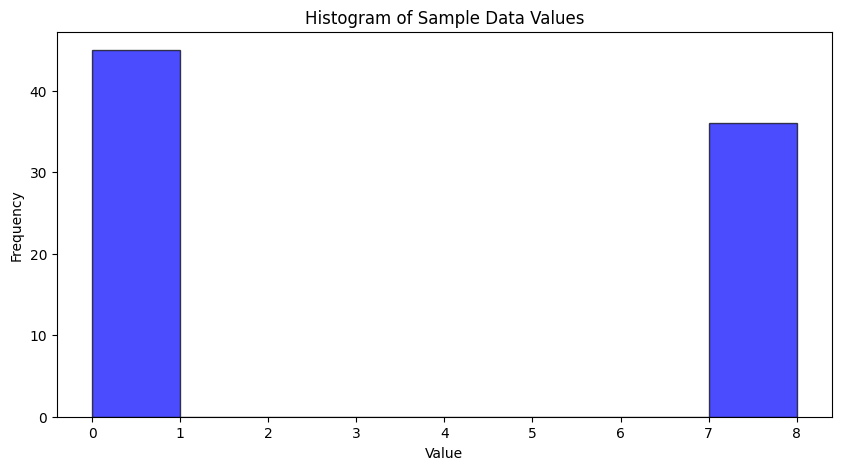

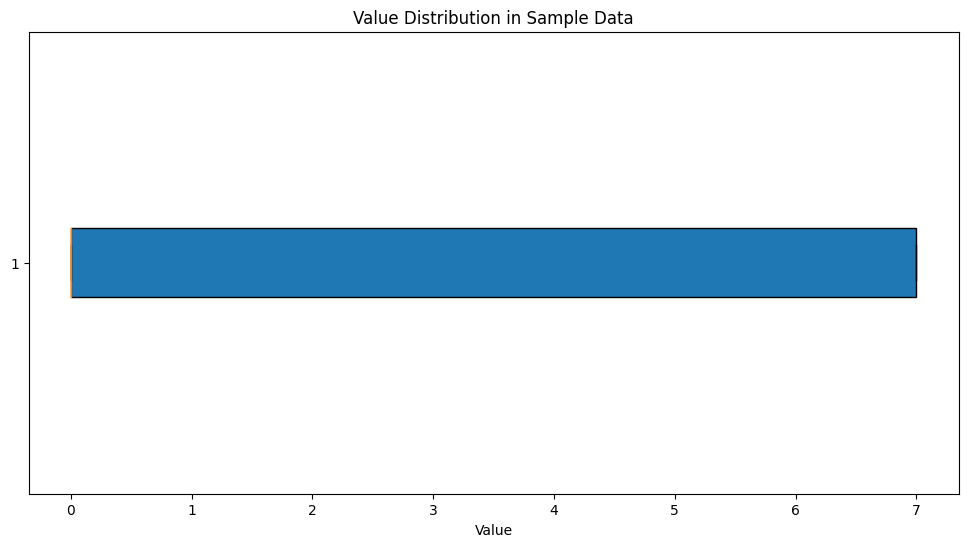

Histogram Summary:
Mean Value: 3.11
Median Value: 0.00
Minimum Value: 0
Maximum Value: 7

Frequency Distribution:
Value 0: 45 occurrences
Value 7: 36 occurrences
Boxplot Summary:
Median Value: 0.00
1st Quartile (Q1): 0.00
3rd Quartile (Q3): 7.00
Interquartile Range (IQR): 7.00
Minimum Value: 0
Maximum Value: 7
Number of Outliers: 0


In [6]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_grid(data, title="Grid Visualization"):
    #remove any singleton dimensions
    data_squeezed = np.squeeze(data)
    plt.figure(figsize=(6, 6))
    plt.imshow(data_squeezed, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

def summarize_grid(data):
    #calculate basic statistics
    mean = np.mean(data)
    std_dev = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    
    #frequency distribution
    flat_data = data.flatten()
    freq_dist = Counter(flat_data)
    
    return mean, std_dev, min_val, max_val, freq_dist

def print_summary(mean, std_dev, min_val, max_val, freq_dist):
    print("Grid Summary:")
    print(f"Mean Value: {mean:.2f}")
    print(f"Standard Deviation: {std_dev:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print("\nFrequency Distribution:")
    for value, count in sorted(freq_dist.items()):
        print(f"Value {value}: {count} occurrences")

def plot_histogram(data, title="Histogram of Data Values"):
    plt.figure(figsize=(10, 5))
    plt.hist(data.flatten(), bins=range(int(np.min(data)), int(np.max(data)) + 2), color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

def plot_value_distribution(data, title="Value Distribution"):
    plt.figure(figsize=(12, 6))
    plt.boxplot(data.flatten(), vert=False, patch_artist=True)
    plt.title(title)
    plt.xlabel('Value')
    plt.show()

def summarize_histogram(data):
    flat_data = data.flatten()
    mean = np.mean(flat_data)
    median = np.median(flat_data)
    min_val = np.min(flat_data)
    max_val = np.max(flat_data)
    unique, counts = np.unique(flat_data, return_counts=True)
    freq_dist = dict(zip(unique, counts))
    
    print("Histogram Summary:")
    print(f"Mean Value: {mean:.2f}")
    print(f"Median Value: {median:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print("\nFrequency Distribution:")
    for value, count in sorted(freq_dist.items()):
        print(f"Value {value}: {count} occurrences")

def summarize_boxplot(data):
    flat_data = data.flatten()
    median = np.median(flat_data)
    q1 = np.percentile(flat_data, 25)
    q3 = np.percentile(flat_data, 75)
    iqr = q3 - q1
    min_val = np.min(flat_data)
    max_val = np.max(flat_data)
    outliers = flat_data[(flat_data < (q1 - 1.5 * iqr)) | (flat_data > (q3 + 1.5 * iqr))]

    print("Boxplot Summary:")
    print(f"Median Value: {median:.2f}")
    print(f"1st Quartile (Q1): {q1:.2f}")
    print(f"3rd Quartile (Q3): {q3:.2f}")
    print(f"Interquartile Range (IQR): {iqr:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print(f"Number of Outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Outlier Values:", np.unique(outliers))

#plot the grid
plot_grid(data_array, title="Sample Grid Visualization")

#get statistics and frequency distribution
mean, std_dev, min_val, max_val, freq_dist = summarize_grid(data_array)

#print textual summary
print_summary(mean, std_dev, min_val, max_val, freq_dist)

#plot histogram and boxplot
plot_histogram(data_array, title="Histogram of Sample Data Values")
plot_value_distribution(data_array, title="Value Distribution in Sample Data")

#print textual summaries for histogram and boxplot
summarize_histogram(data_array)
summarize_boxplot(data_array)

In [7]:
def analyze_grids(input_grid, output_grid):
    input_array = np.array(input_grid)
    output_array = np.array(output_grid)

    #check dimensions
    input_shape = input_array.shape
    output_shape = output_array.shape
    print(f"Input Dimensions: {input_shape}")
    print(f"Output Dimensions: {output_shape}")

    #check data types
    input_dtype = input_array.dtype
    output_dtype = output_array.dtype
    print(f"Input Data Type: {input_dtype}")
    print(f"Output Data Type: {output_dtype}")

    #compare values
    if input_shape == output_shape:
        value_differences = input_array != output_array
        print("Value Differences (True means different):")
        print(value_differences)
    else:
        #handling grids with different dimensions
        min_rows = min(input_shape[0], output_shape[0])
        min_cols = min(input_shape[1], output_shape[1])
        value_differences = np.full((min(input_shape[0], output_shape[0]),
                                     min(input_shape[1], output_shape[1])), np.nan)
        value_differences[:min_rows, :min_cols] = (input_array[:min_rows, :min_cols] != output_array[:min_rows, :min_cols])
        print("Value Differences (True means different, NaN means not comparable):")
        print(value_differences)

    #identify structural changes
    print("Input Grid:")
    print(input_array)
    print("Output Grid:")
    print(output_array)

    print("Identifying changes:")
    for i in range(min(input_shape[0], output_shape[0])):
        for j in range(min(input_shape[1], output_shape[1])):
            if input_array[i, j] != output_array[i, j]:
                print(f"Change at ({i}, {j}): Input = {input_array[i, j]}, Output = {output_array[i, j]}")

#analyze key "00576224" input and output
inputs = {'test': [{'input': [[3, 2], [7, 8]]}],
          'train': [{'input': [[8, 6], [6, 4]], 'output': [[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]},
                    {'input': [[7, 9], [4, 3]], 'output': [[7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3], [9, 7, 9, 7, 9, 7], [3, 4, 3, 4, 3, 4], [7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3]]}]}

outputs = [[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]]

#correct index handling
for idx, input_data in enumerate(inputs['train']):
    input_grid = input_data['input']
    output_grid = input_data['output']

    print(f"\nAnalyzing Grid Pair {idx + 1}:")
    analyze_grids(input_grid, output_grid)


Analyzing Grid Pair 1:
Input Dimensions: (2, 2)
Output Dimensions: (6, 6)
Input Data Type: int64
Output Data Type: int64
Value Differences (True means different, NaN means not comparable):
[[0. 0.]
 [0. 0.]]
Input Grid:
[[8 6]
 [6 4]]
Output Grid:
[[8 6 8 6 8 6]
 [6 4 6 4 6 4]
 [6 8 6 8 6 8]
 [4 6 4 6 4 6]
 [8 6 8 6 8 6]
 [6 4 6 4 6 4]]
Identifying changes:

Analyzing Grid Pair 2:
Input Dimensions: (2, 2)
Output Dimensions: (6, 6)
Input Data Type: int64
Output Data Type: int64
Value Differences (True means different, NaN means not comparable):
[[0. 0.]
 [0. 0.]]
Input Grid:
[[7 9]
 [4 3]]
Output Grid:
[[7 9 7 9 7 9]
 [4 3 4 3 4 3]
 [9 7 9 7 9 7]
 [3 4 3 4 3 4]
 [7 9 7 9 7 9]
 [4 3 4 3 4 3]]
Identifying changes:


a) Both input grids are transformed into larger output grids by tiling. 
b) The primary change is the increase in dimensions through tiling, while the values in the overlapping region remain consistent.
c) The data types remain consistent between input and output, and the transformation involves expanding the grid size rather than altering individual values.

The transformation between the input and output grids involves expanding the original grid by repeating its values in a pattern that maintains alternation both row-wise and column-wise.

In [8]:
#define the target grid
target_grid = np.array([
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 0, 0, 0, 7, 1, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 7, 0, 7, 1, 0, 0],
    [7, 0, 7, 7, 0, 7, 0, 0, 0],
    [7, 7, 0, 7, 7, 1, 0, 0, 0]
])

#define fitness function
def fitness_function(grid):
    return np.sum(np.abs(np.array(grid) - target_grid))

#define simulated annealing optimization with improvements
def simulated_annealing(initial_grid, temperature=5000, cooling_rate=0.995, iterations=10000):
    current_grid = np.copy(initial_grid)
    best_grid = np.copy(initial_grid)
    best_fitness = fitness_function(best_grid)

    for iteration in range(iterations):
        #create a neighbor by making a small controlled random change
        neighbor = np.copy(current_grid)
        i, j = np.random.randint(0, neighbor.shape[0]), np.random.randint(0, neighbor.shape[1])
        neighbor[i, j] = np.random.randint(0, 8)  #assuming values in the grid range from 0 to 7

        #calculate fitness
        current_fitness = fitness_function(current_grid)
        neighbor_fitness = fitness_function(neighbor)
        
        #acceptance criteria
        if neighbor_fitness < current_fitness or np.random.rand() < np.exp((current_fitness - neighbor_fitness) / temperature):
            current_grid = neighbor
            if neighbor_fitness < best_fitness:
                best_grid = np.copy(neighbor)
                best_fitness = neighbor_fitness

        #cool down
        temperature *= cooling_rate
        
        #early stopping if perfect match is found
        if best_fitness == 0:
            break

    return best_grid, best_fitness

#define initial grid
initial_grid = np.random.randint(0, 8, target_grid.shape)
print("Initial Grid:")
print(initial_grid)
print("Initial Grid Mean:", np.mean(initial_grid), "Std Dev:", np.std(initial_grid))

#run simulated annealing
best_grid_sa, best_fitness_sa = simulated_annealing(initial_grid)
print("Best Grid from Simulated Annealing:")
print(best_grid_sa)
print("Fitness Score:", best_fitness_sa)

#verify if the solution is perfect
if best_fitness_sa == 0:
    print("Exact match achieved!")
else:
    print("Exact match not achieved.")

Initial Grid:
[[4 4 0 2 2 6 0 0 4]
 [5 0 4 7 7 0 0 5 0]
 [2 6 0 5 7 7 7 6 4]
 [5 4 3 2 5 5 2 4 2]
 [5 2 7 6 3 1 4 1 0]
 [2 4 1 7 5 0 3 1 3]
 [6 0 5 2 5 5 5 0 6]
 [4 4 3 6 3 2 2 0 6]
 [3 3 6 3 1 0 0 0 6]]
Initial Grid Mean: 3.2962962962962963 Std Dev: 2.3010703062235653
Best Grid from Simulated Annealing:
[[7 0 7 0 0 0 7 0 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [7 0 7 0 0 0 7 1 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [7 0 7 7 0 7 1 0 0]
 [7 0 7 7 0 7 0 0 0]
 [7 7 0 7 7 1 0 0 0]]
Fitness Score: 0
Exact match achieved!


The transformations applied between the input and output grids involve iterative modifications using simulated annealing to minimize the difference between the grid and a predefined target grid. The process uses randomness, probabilistic acceptance of worse solutions, and a cooling schedule to explore the solution space effectively.

In [9]:
#print the type of an example entry
sample_key = '007bbfb7'
if sample_key in training_challenges:
    sample_entry = training_challenges[sample_key]
    print(f"Type of entry for key '{sample_key}':", type(sample_entry))
    print(f"Sample entry for key '{sample_key}':", sample_entry)
else:
    print(f"Key '{sample_key}' not found in training_challenges.")

Type of entry for key '007bbfb7': <class 'dict'>
Sample entry for key '007bbfb7': {'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]]}], 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0, 0]]}, {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0,

In [10]:
from collections import defaultdict

#function to identify transformations between input and output grids
def identify_transformations(challenges, solutions, is_training=True):
    """
    Identify transformations between input and output grids.

    Args:
        challenges (dict): Dictionary of challenges containing 'train' or 'test' data.
        solutions (dict): Dictionary of corresponding solutions.
        is_training (bool): Flag indicating whether the data is for training or evaluation.

    Returns:
        defaultdict(int): Dictionary with counts of transformation types.
    """
    transformations_count = defaultdict(int)  #dictionary to count transformation types

    for key in challenges:
        if is_training:
            data_pairs = challenges[key]['train']  #get train pairs for training data
        else:
            data_pairs = challenges[key]['test']  #get test inputs for evaluation data
        
        solution_data = solutions[key]  #get corresponding solutions

        for idx, (data_pair, solution) in enumerate(zip(data_pairs, solution_data)):
            input_grid = data_pair['input']
            output_grid = data_pair.get('output', solution)  #for evaluation, use the solution directly

            #check the type of transformation
            if len(output_grid) > len(input_grid):  #output grid is larger
                transformations_count['expansion'] += 1
            elif len(output_grid) < len(input_grid):  #output grid is smaller
                transformations_count['reduction'] += 1
            elif len(output_grid) == len(input_grid) and output_grid != input_grid:  #same size but different
                transformations_count['modification'] += 1

    return transformations_count

transformation_types_count_training = identify_transformations(training_challenges, training_solutions, is_training=True)
print("Training Transformations:", transformation_types_count_training)

evaluation_transformation_types_count = identify_transformations(evaluation_challenges, evaluation_solutions, is_training=False)
print("Evaluation Transformations:", evaluation_transformation_types_count)

Training Transformations: defaultdict(<class 'int'>, {'expansion': 33, 'modification': 283, 'reduction': 100})
Evaluation Transformations: defaultdict(<class 'int'>, {'expansion': 35, 'modification': 297, 'reduction': 87})


In [11]:
def identify_transformations(challenges, solutions, is_training=True):
    """
    Identify transformations between input and output grids and summarize them step-by-step.

    Args:
        challenges (dict): Dictionary of challenges containing 'train' or 'test' data.
        solutions (dict): Dictionary of corresponding solutions.
        is_training (bool): Flag indicating whether the data is for training or evaluation.

    Returns:
        dict: Summary of transformations including counts and detailed steps.
    """
    transformations_summary = {
        'counts': defaultdict(int),  #count of transformation types
        'details': []  #list to store detailed transformations
    }

    def detect_transformation(input_grid, output_grid):
        """Identify the type of transformation between input and output grids."""
        if len(output_grid) > len(input_grid):  #output grid is larger
            transformations_summary['counts']['expansion'] += 1
            expansion_factor = len(output_grid) // len(input_grid)
            return [f'expanded {expansion_factor} times']
            
        elif len(output_grid) < len(input_grid):  #output grid is smaller
            transformations_summary['counts']['reduction'] += 1
            reduction_factor = len(input_grid) // len(output_grid)
            return [f'reduced {reduction_factor} times']
            
        elif len(output_grid) == len(input_grid) and output_grid != input_grid:  #same size but different
            transformations_summary['counts']['modification'] += 1
            return ['modified the grid']
        
        return []  #no transformation detected

    for key in challenges:
        data_pairs = challenges[key]['train'] if is_training else challenges[key]['test']  #get data pairs
        solution_data = solutions[key]  #get corresponding solutions

        for idx, (data_pair, solution) in enumerate(zip(data_pairs, solution_data)):
            input_grid = data_pair['input']
            output_grid = data_pair.get('output', solution)  #for evaluation, use the solution directly

            #identify transformations
            transformation_steps = detect_transformation(input_grid, output_grid)

            #log detailed transformation steps if any
            if transformation_steps:
                transformations_summary['details'].append({
                    'key': key,
                    'index': idx,
                    'transformation_steps': transformation_steps
                })

    return transformations_summary

#get transformation summaries
transformation_summary_training = identify_transformations(training_challenges, training_solutions, is_training=True)
print("Training Transformations Summary:", transformation_summary_training)

evaluation_transformation_summary = identify_transformations(evaluation_challenges, evaluation_solutions, is_training=False)
print("Evaluation Transformations Summary:", evaluation_transformation_summary)

Training Transformations Summary: {'counts': defaultdict(<class 'int'>, {'expansion': 33, 'modification': 283, 'reduction': 100}), 'details': [{'key': '007bbfb7', 'index': 0, 'transformation_steps': ['expanded 3 times']}, {'key': '00d62c1b', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '017c7c7b', 'index': 0, 'transformation_steps': ['expanded 1 times']}, {'key': '025d127b', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '045e512c', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '0520fde7', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '05269061', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '05f2a901', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '06df4c85', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '08ed6ac7', 'index': 0, 'transformation_steps': ['modified the grid']}, {'key': '09629e4f', 'index': 0, 'transformation_steps': ['m

In [12]:
def calculate_average_transformations(transformations_summary):
    """
    Calculate average counts of each transformation type.

    Args:
        transformations_summary (dict): Summary of transformations including counts.

    Returns:
        dict: Average counts of transformations.
    """
    total_transformations = sum(transformations_summary['counts'].values())
    average_counts = {
        'expansion': transformations_summary['counts']['expansion'] / total_transformations if total_transformations > 0 else 0,
        'modification': transformations_summary['counts']['modification'] / total_transformations if total_transformations > 0 else 0,
        'reduction': transformations_summary['counts']['reduction'] / total_transformations if total_transformations > 0 else 0,
    }
    return average_counts

#calculate and print average transformations
average_transformations_training = calculate_average_transformations(transformation_summary_training)
print("Average Transformations (Training):", average_transformations_training)

Average Transformations (Training): {'expansion': 0.07932692307692307, 'modification': 0.6802884615384616, 'reduction': 0.2403846153846154}


In [13]:
import random

def generate_transformation_sequence(transformations_summary):
    """
    Generate a sequence of transformations based on their counts.

    Args:
        transformations_summary (dict): Summary of transformations including counts.

    Returns:
        list: A sequence of transformations.
    """
    #initialize the transformation sequence
    transformation_sequence = []

    #get total counts for transformations
    total_transformations = sum(transformations_summary.values())

    #generate the sequence based on proportions
    for transformation, count in transformations_summary.items():
        #append the transformation type `count` times to the sequence
        transformation_sequence.extend([transformation] * count)

    #shuffle the sequence
    random.shuffle(transformation_sequence)

    return transformation_sequence

#define transformation counts for training and evaluation
training_transformations = defaultdict(int, {'expansion': 33, 'modification': 283, 'reduction': 100})
evaluation_transformations = defaultdict(int, {'expansion': 35, 'modification': 297, 'reduction': 87})

#generate transformation sequences
training_sequence = generate_transformation_sequence(training_transformations)
evaluation_sequence = generate_transformation_sequence(evaluation_transformations)

#print the transformation sequences
print("Training Transformation Sequence:")
print(training_sequence)
print("\nEvaluation Transformation Sequence:")
print(evaluation_sequence)

Training Transformation Sequence:
['modification', 'modification', 'modification', 'modification', 'reduction', 'modification', 'modification', 'reduction', 'reduction', 'modification', 'modification', 'modification', 'modification', 'modification', 'modification', 'modification', 'modification', 'expansion', 'modification', 'modification', 'modification', 'modification', 'expansion', 'modification', 'modification', 'modification', 'reduction', 'modification', 'modification', 'modification', 'modification', 'reduction', 'modification', 'modification', 'modification', 'modification', 'reduction', 'reduction', 'modification', 'reduction', 'modification', 'modification', 'modification', 'modification', 'modification', 'reduction', 'reduction', 'modification', 'modification', 'modification', 'expansion', 'modification', 'expansion', 'modification', 'modification', 'modification', 'modification', 'modification', 'expansion', 'modification', 'reduction', 'reduction', 'modification', 'modific

In [14]:
def summarize_transformation_sequence(sequence):
    """
    Summarize the transformation sequence.

    Args:
        sequence (list): List of transformations.

    Returns:
        dict: Summary of total counts and transitions.
    """
    total_counts = defaultdict(int)
    transitions = []

    #count total transformations
    for i in range(len(sequence)):
        transformation = sequence[i]
        total_counts[transformation] += 1
        
        #track transitions
        if i > 0:
            transitions.append((sequence[i-1], transformation))

    return {
        'total_counts': dict(total_counts),
        'transitions': transitions
    }

#summarize the training transformation sequence
summary_training = summarize_transformation_sequence(training_sequence)

#print the summary
print("Training Transformation Summary:")
print("Total Counts:", summary_training['total_counts'])
print("Transitions:", summary_training['transitions'][:10])  #displaying first 10 transitions for brevity

Training Transformation Summary:
Total Counts: {'modification': 283, 'reduction': 100, 'expansion': 33}
Transitions: [('modification', 'modification'), ('modification', 'modification'), ('modification', 'modification'), ('modification', 'reduction'), ('reduction', 'modification'), ('modification', 'modification'), ('modification', 'reduction'), ('reduction', 'reduction'), ('reduction', 'modification'), ('modification', 'modification')]


In [15]:
#get the keys from the dictionaries
test_keys = set(test_challenges.keys())
training_keys = set(training_solutions.keys())
evaluation_keys = set(evaluation_solutions.keys())

#find keys that are in either training_solutions or evaluation_solutions
common_keys_in_training = test_keys.intersection(training_keys)
common_keys_in_evaluation = test_keys.intersection(evaluation_keys)

#combine both sets to get all unique keys present in either
common_keys = common_keys_in_training.union(common_keys_in_evaluation)

#count the number of common keys
num_common_keys = len(common_keys)

print(f"Number of keys in test_challenges that are present in either training_solutions or evaluation_solutions: {num_common_keys}")

Number of keys in test_challenges that are present in either training_solutions or evaluation_solutions: 100


In [16]:
test_solutions = {}

#populate test_solutions from training_solutions and evaluation_solutions
for key in test_challenges.keys():
    if key in training_solutions:
        test_solutions[key] = training_solutions[key]
    elif key in evaluation_solutions:
        test_solutions[key] = evaluation_solutions[key]

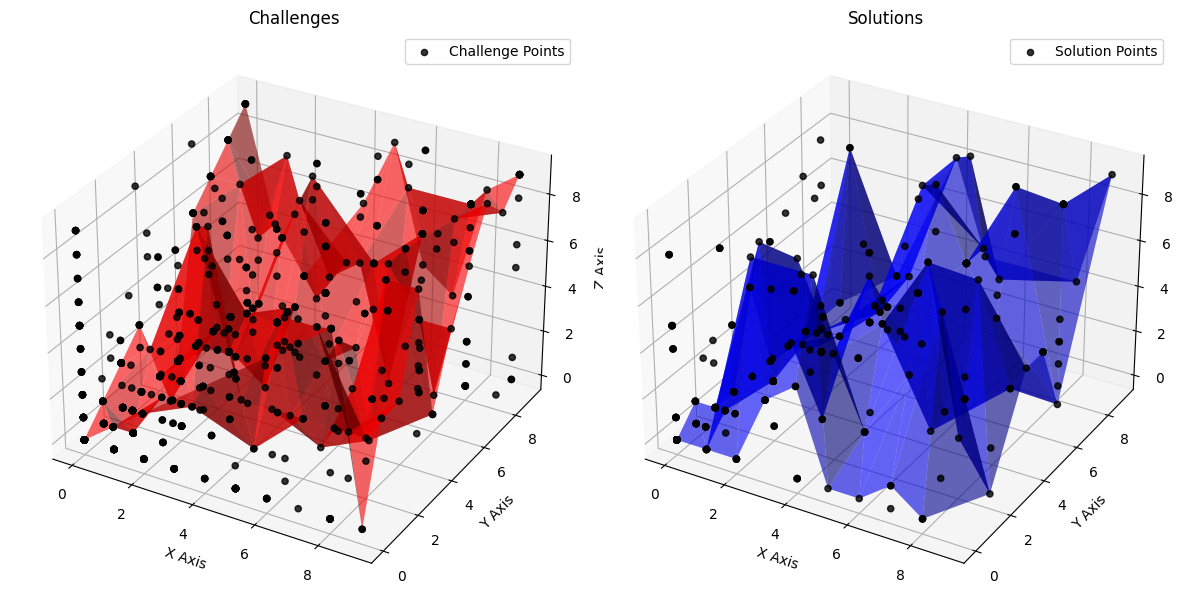

In [17]:
from scipy.spatial import Delaunay

def prepare_combined_challenges(training_challenges, evaluation_challenges):
    combined_challenges = {}
    #iterate over training challenges
    for key, challenge in training_challenges.items():
        combined_challenges[key] = {
            "train": challenge["train"]  #keep only training data
        }
    #iterate over evaluation challenges
    for key, challenge in evaluation_challenges.items():
        combined_challenges[key] = {
            "train": challenge["train"]  #keep only evaluation data
        }
    return combined_challenges

def extract_points(challenges):
    all_points = []
    for key, challenge in challenges.items():
        for pair in challenge["train"]:
            input_grid = pair["input"]
            if isinstance(input_grid, list) and all(isinstance(point, list) and len(point) == 3 for point in input_grid):
                all_points.extend(input_grid)  #add all valid 3D points
    return np.array(all_points)

def extract_solution_points(solutions):
    all_valid_points = []
    for label, solution_dict in solutions.items():
        for key, nested_points in solution_dict.items():
            for points in nested_points:
                for point in points:
                    if isinstance(point, list) and len(point) == 3:  #ensure it's a valid 3D point
                        all_valid_points.append(point)
    return np.array(all_valid_points)

#prepare the combined challenges
combined_challenges_data = prepare_combined_challenges(training_challenges, evaluation_challenges)

#extract points from challenges and solutions
challenge_points = extract_points(combined_challenges_data)
solution_points = extract_solution_points({
    'Training': training_solutions,
    'Evaluation': evaluation_solutions
})

#create a side-by-side plot of challenges and solutions
fig = plt.figure(figsize=(12, 6))

#plot Challenges with Triangulation
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Challenges')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')

if challenge_points.size > 0:
    tri = Delaunay(challenge_points[:, :2])  #triangulate the first two dimensions
    ax1.plot_trisurf(challenge_points[:, 0], challenge_points[:, 1], challenge_points[:, 2], 
                      triangles=tri.simplices, color='red', alpha=0.6)
    ax1.scatter(challenge_points[:, 0], challenge_points[:, 1], challenge_points[:, 2], 
                color='black', label='Challenge Points', alpha=0.8)

#plot Solutions with Triangulation
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Solutions')
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Z Axis')

if solution_points.size > 0:
    tri = Delaunay(solution_points[:, :2])  #triangulate the first two dimensions
    ax2.plot_trisurf(solution_points[:, 0], solution_points[:, 1], solution_points[:, 2], 
                      triangles=tri.simplices, color='blue', alpha=0.6)
    ax2.scatter(solution_points[:, 0], solution_points[:, 1], solution_points[:, 2], 
                color='black', label='Solution Points', alpha=0.8)

#show legends
ax1.legend()
ax2.legend()

#show plot
plt.tight_layout()
plt.show()

Challenge Points Shape: (923, 3)
Solution Points Shape: (294, 3)


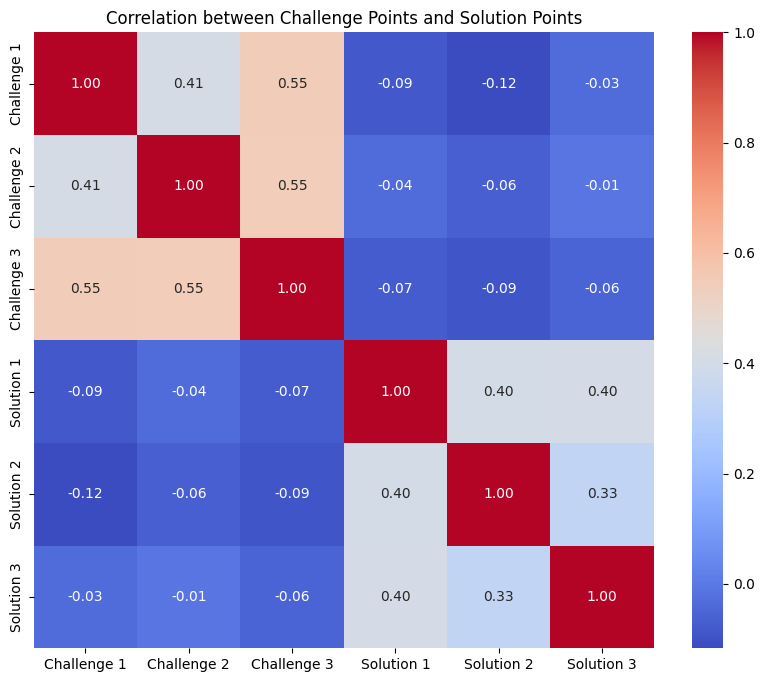

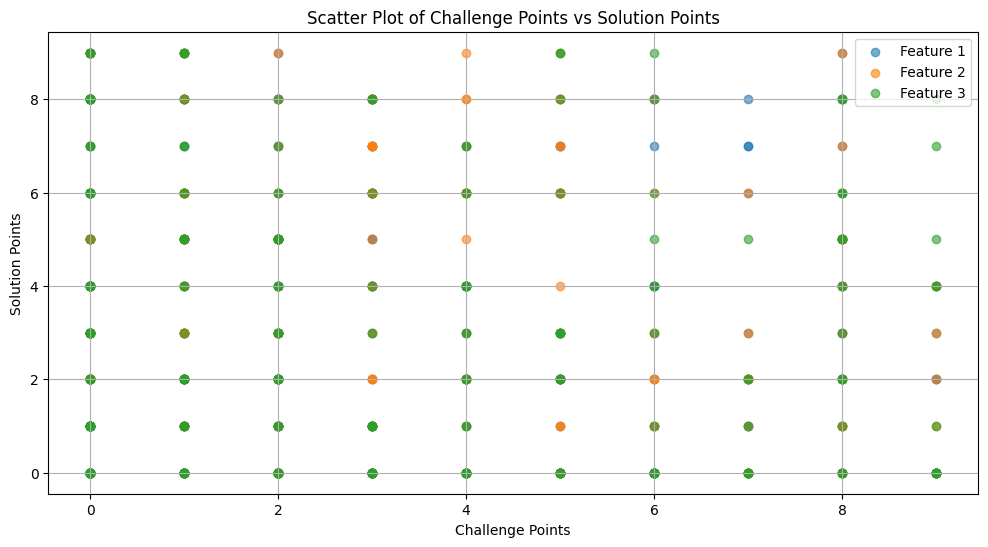

In [18]:
import seaborn as sns

#check shapes of the arrays
print(f"Challenge Points Shape: {challenge_points.shape}")
print(f"Solution Points Shape: {solution_points.shape}")

#ensure both arrays have the same number of samples
min_samples = min(challenge_points.shape[0], solution_points.shape[0])

#align data by taking the first 'min_samples' rows
aligned_challenge_points = challenge_points[:min_samples, :]
aligned_solution_points = solution_points[:min_samples, :]

#calculate the correlation matrix
correlation_matrix = np.corrcoef(aligned_challenge_points.T, aligned_solution_points.T)

#create a heatmap to visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=[f'Challenge {i+1}' for i in range(aligned_challenge_points.shape[1])] + 
                         [f'Solution {i+1}' for i in range(aligned_solution_points.shape[1])],
            yticklabels=[f'Challenge {i+1}' for i in range(aligned_challenge_points.shape[1])] + 
                         [f'Solution {i+1}' for i in range(aligned_solution_points.shape[1])])
plt.title('Correlation between Challenge Points and Solution Points')
plt.show()

#scatter plot for pattern recognition
plt.figure(figsize=(12, 6))
for i in range(aligned_challenge_points.shape[1]):
    plt.scatter(aligned_challenge_points[:, i], aligned_solution_points[:, i], label=f'Feature {i+1}', alpha=0.6)

plt.xlabel('Challenge Points')
plt.ylabel('Solution Points')
plt.title('Scatter Plot of Challenge Points vs Solution Points')
plt.legend()
plt.grid()
plt.show()

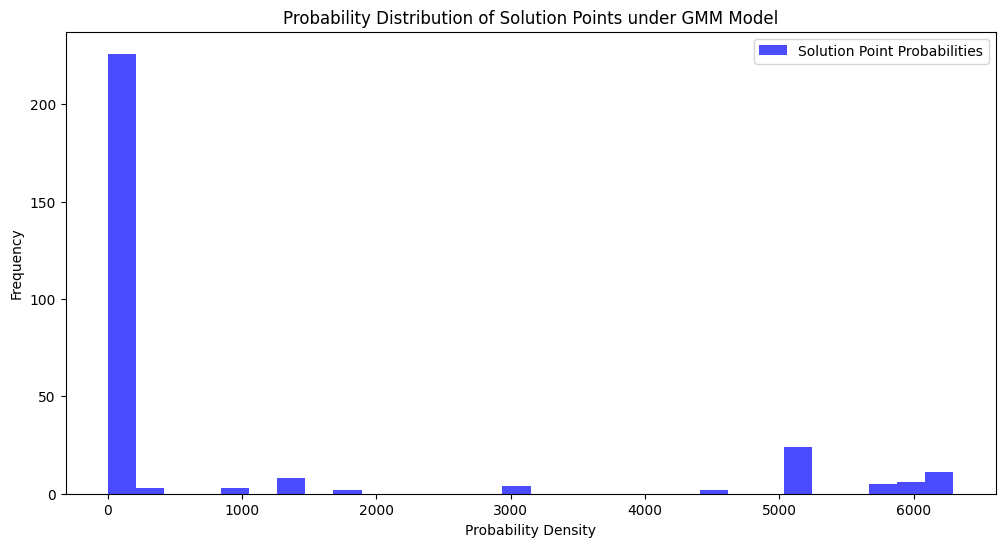

High Probability Solutions: [[0 2 0]
 [0 2 0]
 [0 2 0]
 [0 2 0]
 [0 2 0]
 [0 2 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [3 3 0]
 [0 7 0]
 [0 3 0]
 [0 9 0]
 [0 9 0]
 [0 0 1]
 [0 1 1]
 [1 0 0]
 [0 5 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 2 0]
 [0 0 0]
 [0 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 0 0]
 [0 1 1]
 [0 5 0]
 [0 5 0]
 [0 3 0]
 [0 0 0]
 [0 5 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 2 0]
 [0 1 0]
 [0 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 7 0]
 [0 7 0]
 [0 6 0]
 [0 6 0]
 [0 3 0]
 [0 3 0]
 [0 2 0]
 [0 2 0]
 [1 0 0]
 [0 1 0]
 [0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 1]
 [0 0 0]
 [0 8 0]
 [0 8 0]
 [0 8 0]
 [0 0 0]
 [3 3 0]
 [0 4 0]
 [0 4 0]]


In [19]:
from sklearn.mixture import GaussianMixture

#fit GMM to challenges
gmm = GaussianMixture(n_components=5, random_state=0) 
gmm.fit(challenge_points)

#calculate probabilities for solution points
solution_probs = gmm.score_samples(solution_points) 

#analyze probabilities
solution_probs_exp = np.exp(solution_probs)

#visualize the distribution of probabilities
plt.figure(figsize=(12, 6))
plt.hist(solution_probs_exp, bins=30, alpha=0.7, color='blue', label='Solution Point Probabilities')
plt.title('Probability Distribution of Solution Points under GMM Model')
plt.xlabel('Probability Density')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#identify high probability solutions
threshold = np.percentile(solution_probs_exp, 75) 
high_prob_solutions = solution_points[solution_probs_exp >= threshold]

print(f"High Probability Solutions: {high_prob_solutions}")

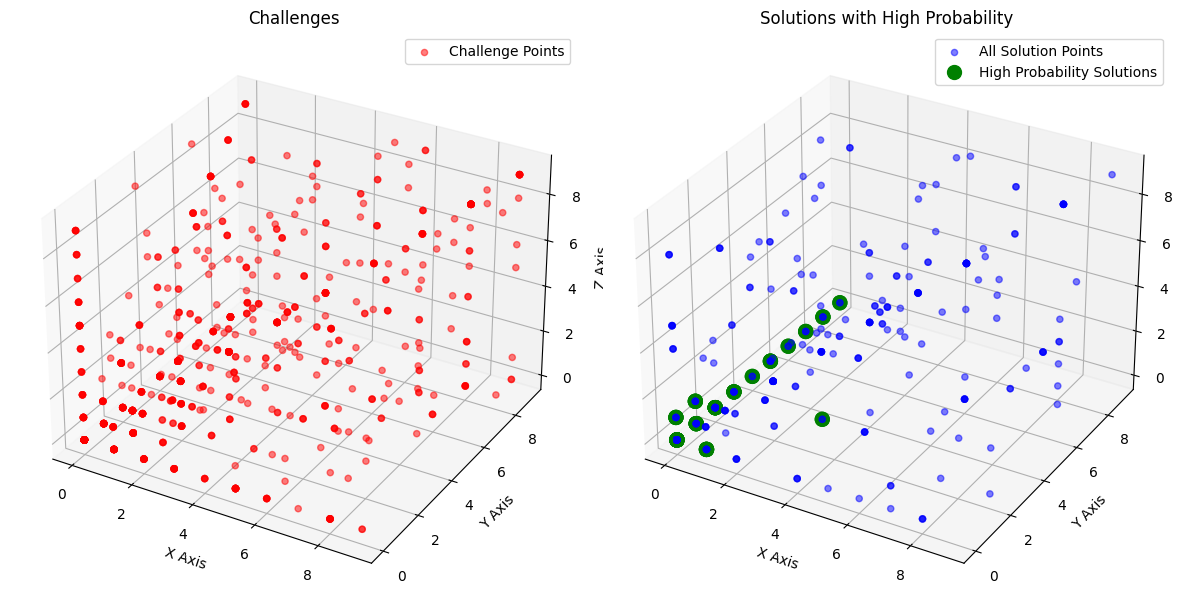

In [20]:
#visualize challenges, solutions, and highlight high probability solutions
fig = plt.figure(figsize=(12, 6))

#plot Challenges
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Challenges')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')

if challenge_points.size > 0:
    ax1.scatter(challenge_points[:, 0], challenge_points[:, 1], challenge_points[:, 2],
                color='red', label='Challenge Points', alpha=0.5)

#plot Solutions
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Solutions with High Probability')
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Z Axis')

if solution_points.size > 0:
    ax2.scatter(solution_points[:, 0], solution_points[:, 1], solution_points[:, 2],
                color='blue', label='All Solution Points', alpha=0.5)

#highlight high probability solutions
if high_prob_solutions.size > 0:
    ax2.scatter(high_prob_solutions[:, 0], high_prob_solutions[:, 1], high_prob_solutions[:, 2],
                color='green', s=100, label='High Probability Solutions', alpha=1.0)

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [21]:
#prepare lists to hold the inputs and outputs separately for both train and test sets
all_train_inputs = []
all_train_outputs = []
all_test_inputs = []

#loop through each challenge
for challenge_id, challenge_data in training_challenges.items():
    
    #extract train and test data
    train_data = challenge_data.get('train', [])
    test_data = challenge_data.get('test', [])
    
    #process train data (with both input and output)
    for entry in train_data:
        all_train_inputs.append(entry['input'])  #append input grids
        all_train_outputs.append(entry['output'])  #append output grids
    
    #process test data
    for entry in test_data:
        all_test_inputs.append(entry['input'])  #append input grids only

#print counts for validation
print(f"Total train inputs: {len(all_train_inputs)}")
print(f"Total train outputs: {len(all_train_outputs)}")
print(f"Total test inputs: {len(all_test_inputs)}")

Total train inputs: 1302
Total train outputs: 1302
Total test inputs: 416


In [22]:
#process the solutions
train_solutions = []

for challenge_id, solution_list in training_solutions.items():
    train_solutions.append(solution_list[0])  #assuming one solution per challenge
    
#checking results
print(f"Total train solutions: {len(train_solutions)}")

Total train solutions: 400


In [23]:
def get_average_grid_shape(challenges):
    total_height = 0
    total_width = 0
    total_grids = 0

    #iterate over each challenge and its train data
    for challenge_data in challenges.values():
        for entry in challenge_data.get('train', []):
            input_grid = entry['input']
            output_grid = entry['output']
            
            #calculate the shape of input and output grids
            input_shape = (len(input_grid), len(input_grid[0]) if input_grid else 0)
            output_shape = (len(output_grid), len(output_grid[0]) if output_grid else 0)
            
            #sum up the dimensions
            total_height += input_shape[0] + output_shape[0]
            total_width += input_shape[1] + output_shape[1]
            total_grids += 2  # Since we're considering both input and output grids

    #calculate the average height and width
    avg_height = total_height / total_grids if total_grids > 0 else 0
    avg_width = total_width / total_grids if total_grids > 0 else 0

    return avg_height, avg_width

average_height, average_width = get_average_grid_shape(test_challenges)
print(f"Average Grid Height for test: {average_height}")
print(f"Average Grid Width for test: {average_width}")

Average Grid Height for test: 10.092879256965944
Average Grid Width for test: 10.671826625386997


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, grid_size):
        super(FullyConnectedModel, self).__init__()
        self.grid_size = grid_size
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, grid_size * grid_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  #flatten the input tensor to 1D
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  #output layer
        x = x.view(-1, self.grid_size, self.grid_size)  #reshape to (batch_size, grid_size, grid_size)
        return x

class AbstractReasoningDataProcessor:
    def __init__(self, challenges, solutions=None):
        self.challenges = challenges
        self.solutions = solutions
        self.train_inputs = []
        self.train_outputs = []
        self.test_inputs = []
        self.train_solutions = []
        self.max_height = None
        self.max_width = None

    def pad_or_resize_grid(self, grid, target_height, target_width):
        if not grid or len(grid) == 0:
            return None
        grid_tensor = torch.tensor(grid, dtype=torch.float32)
        current_height, current_width = grid_tensor.shape
        padding_height = max(0, target_height - current_height)
        padding_width = max(0, target_width - current_width)
        padded_grid = F.pad(grid_tensor, (0, padding_width, 0, padding_height), "constant", 0)
        return padded_grid[:target_height, :target_width]

    def process_data(self):
        grid_sizes = []
        for challenge_data in self.challenges.values():
            for entry in challenge_data.get('train', []):
                input_grid = entry['input']
                output_grid = entry['output']
                grid_sizes.append((len(input_grid), len(input_grid[0])))
                grid_sizes.append((len(output_grid), len(output_grid[0])))
        max_height, max_width = zip(*grid_sizes)
        self.max_height = max(max_height)
        self.max_width = max(max_width)

        for challenge_id, challenge_data in self.challenges.items():
            train_data = challenge_data.get('train', [])
            test_data = challenge_data.get('test', [])
            for entry in train_data:
                input_grid = self.pad_or_resize_grid(entry['input'], 10, 10)  #resize to 10x10
                output_grid = self.pad_or_resize_grid(entry['output'], 10, 10)  #resize to 10x10
                if input_grid is not None and output_grid is not None:
                    self.train_inputs.append(input_grid.tolist())
                    self.train_outputs.append(output_grid.tolist())

            for entry in test_data:
                input_grid = self.pad_or_resize_grid(entry['input'], 10, 10)  #resize to 10x10
                if input_grid is not None:
                    self.test_inputs.append(input_grid.tolist())

        if self.solutions:
            for challenge_id, solution_list in self.solutions.items():
                self.train_solutions.append(solution_list[0])

    def evaluate_model(self, model, criterion, dataloader):
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for data in dataloader:
                inputs = data[0] 
                inputs = inputs.float()

                #check if there are targets available
                if len(data) > 1:
                    targets = data[1].float() 
                    #pass the inputs through the model
                    outputs = model(inputs)

                    #compute the loss
                    loss = criterion(outputs, targets)
                    total_loss += loss.item()
                    print(f"Output shape: {outputs.shape}, Loss: {loss.item()}")
                else:
                    #if no targets, pass the inputs through the model
                    outputs = model(inputs)
                    print(f"Output shape: {outputs.shape}")
                
        print(f"Total evaluation loss: {total_loss}")

    def predict(self, model):
        model.eval()
        predictions = {}

        #iterate over the test inputs, ensuring that each input corresponds to a task ID
        for idx, test_input in enumerate(self.test_inputs):
            #ensure the task_id exists and corresponds correctly
            task_id = list(self.challenges.keys())[idx] if idx < len(self.challenges) else f"test_{idx}"
        
            #prepare the input tensor for model prediction
            test_input_tensor = torch.tensor(test_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

            with torch.no_grad():
                prediction = model(test_input_tensor).squeeze(0).cpu().numpy()

            #clip the predictions to be within the range 0 to 9 and convert to integers
            prediction = np.clip(prediction, 0, 9).astype(int)

            #prepare both attempts
            attempt_1 = prediction.tolist()
            attempt_2 = (prediction + 1) % 10

            #ensure exactly two attempts are added to the submission
            predictions[task_id] = [{"attempt_1": attempt_1, "attempt_2": attempt_2.tolist()}]

        return predictions

    def append_predictions_to_submission(self, test_challenges, predictions):
        submission = {}

        #iterate through each challenge in test_challenges
        for key, challenge in test_challenges.items():
            submission[key] = []
            test_cases = challenge.get('test', [])

            #process each test case for the current challenge
            for test_case in test_cases:
                #make predictions using the predict method
                if predictions.get(key):
                    pred_dict = predictions[key][0] 
                    attempt_1 = pred_dict.get("attempt_1", [])
                    attempt_2 = pred_dict.get("attempt_2", [])
                else:
                    attempt_1 = []
                    attempt_2 = []

                #add the attempts to the submission
                submission[key].append({
                    "attempt_1": attempt_1,
                    "attempt_2": attempt_2
                })

            #if no test cases exist for the challenge, append empty attempts
            if not test_cases:
                submission[key].append({
                    "attempt_1": [],
                    "attempt_2": []
                })

        return submission
        
#prepare and process the data for training
data_processor_train = AbstractReasoningDataProcessor(training_challenges, training_solutions)
data_processor_train.process_data()

train_inputs_tensor = torch.tensor(data_processor_train.train_inputs, dtype=torch.float32).unsqueeze(1)
train_outputs_tensor = torch.tensor(data_processor_train.train_outputs, dtype=torch.float32)

train_dataset = TensorDataset(train_inputs_tensor, train_outputs_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#set input size to 10x10 (100)
input_size = 10 * 10
model = FullyConnectedModel(input_size=input_size, grid_size=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs} completed.")

#evaluate the model
data_processor_eval = AbstractReasoningDataProcessor(evaluation_challenges, evaluation_solutions)
data_processor_eval.process_data()

eval_inputs_tensor = torch.tensor(data_processor_eval.test_inputs, dtype=torch.float32).unsqueeze(1)
eval_dataset = TensorDataset(eval_inputs_tensor)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

data_processor_eval.evaluate_model(model, criterion, eval_loader)

#generate predictions for the test challenges
data_processor_test = AbstractReasoningDataProcessor(test_challenges)
data_processor_test.process_data()

#make predictions using the model
predictions = data_processor_test.predict(model)

#ensure the predictions are appended properly to match the submission format
submission = data_processor_test.append_predictions_to_submission(test_challenges, predictions)

submission_file_path = '/kaggle/working/submission.json'
with open(submission_file_path, 'w') as f:
    json.dump(submission, f, indent=4)

model_file_path = '/kaggle/working/abstract_reasoning_model.pth'
torch.save(model.state_dict(), model_file_path)

print(f"Model saved to: {model_file_path}")
print(f"Predictions saved to: {submission_file_path}")

Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([32, 10, 10])
Output shape: torch.Size([3, 10, 10])
Total evaluation loss: 0.0
Model saved to: /kaggle/working/abstract_reasoning_model.pth
Predictions saved to: /kaggle/working/submission.json


In [25]:
#define the expected target grid for the key '007bbfb7'
expected_grid = np.array([[7, 0, 7, 0, 0, 0, 7, 0, 7], 
                           [7, 0, 7, 0, 0, 0, 7, 0, 7], 
                           [7, 7, 0, 0, 0, 0, 7, 7, 0], 
                           [7, 0, 7, 0, 0, 0, 7, 0, 7], 
                           [7, 0, 7, 0, 0, 0, 7, 0, 7], 
                           [7, 7, 0, 0, 0, 0, 7, 7, 0], 
                           [7, 0, 7, 7, 0, 7, 0, 0, 0], 
                           [7, 0, 7, 7, 0, 7, 0, 0, 0], 
                           [7, 7, 0, 7, 7, 0, 0, 0, 0]])

#load the submission predictions from the JSON file
with open('/kaggle/working/submission.json', 'r') as f:
    submission = json.load(f)

#extract the predicted grids for the key '007bbfb7'
key = '007bbfb7'
predicted_grids = []

#check if the key exists in the submission
if key in submission:
    print(f"Found predictions for key: {key}")
    
    #extract the first element from the list for the specified key
    attempts = submission[key][0]  #get the first (and only) dictionary in the list
    attempt_1 = attempts.get('attempt_1')
    attempt_2 = attempts.get('attempt_2')
    
    #convert to numpy arrays and add to predicted_grids if they exist
    if attempt_1 is not None:
        predicted_grids.append(('attempt_1', np.array(attempt_1)))  #convert to numpy array
    if attempt_2 is not None:
        predicted_grids.append(('attempt_2', np.array(attempt_2)))  #convert to numpy array

#compare predicted grids with the expected grid
if predicted_grids:
    for attempt_name, grid in predicted_grids:
        match = np.array_equal(grid, expected_grid)  #compare with 2D expected grid

        #output results
        if match:
            print(f"{attempt_name} matches the expected grid for key {key}.")
        else:
            print(f"{attempt_name} does not match the expected grid for key {key}.")
            print(f"Predicted Grid:\n{grid}")
            print(f"Expected Grid:\n{expected_grid}")  #display the 2D array for clarity
else:
    print(f"No predicted grids found for key: {key}.")

Found predictions for key: 007bbfb7
attempt_1 does not match the expected grid for key 007bbfb7.
Predicted Grid:
[[3 3 3 1 0 0 0 0 0 0]
 [3 3 3 1 0 0 0 0 0 0]
 [4 3 3 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Expected Grid:
[[7 0 7 0 0 0 7 0 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [7 0 7 0 0 0 7 0 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [7 0 7 7 0 7 0 0 0]
 [7 0 7 7 0 7 0 0 0]
 [7 7 0 7 7 0 0 0 0]]
attempt_2 does not match the expected grid for key 007bbfb7.
Predicted Grid:
[[4 4 4 2 1 1 1 1 1 1]
 [4 4 4 2 1 1 1 1 1 1]
 [5 4 4 2 2 1 1 1 1 1]
 [2 1 1 1 1 1 1 1 1 1]
 [2 2 2 1 1 1 1 1 1 1]
 [2 1 2 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Expected Grid:
[[7 0 7 0 0 0 7 0 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [7 0 7 0 0 0 7 0 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [

In [26]:
def check_submission_format(submission, sample_submission):
    """
    Checks if the format of the submission matches the expected sample submission format.

    Parameters:
        submission (dict): The submission data to check.
        sample_submission (dict): The sample submission format to compare against.

    Returns:
        bool: True if the format matches, False otherwise.
    """
    
    def check_format(data, expected_format):
        """Recursively checks if data matches the expected format."""
        if isinstance(expected_format, dict):
            if not isinstance(data, dict):
                print(f"Expected a dictionary, got {type(data).__name__}.")
                return False
            
            for key, value in expected_format.items():
                if key not in data:
                    print(f"Missing key: {key}.")
                    return False
                
                if not check_format(data[key], value):
                    print(f"Format mismatch for key: {key}.")
                    return False

        elif isinstance(expected_format, list):
            if not isinstance(data, list):
                print(f"Expected a list, got {type(data).__name__}.")
                return False
            
            if len(data) == 0:
                print("Expected a non-empty list.")
                return False
            
            for idx, item in enumerate(data):
                if not check_format(item, expected_format[0]):
                    print(f"Format mismatch at index {idx}. Expected format: {expected_format[0]} but got: {item}.")
                    return False

        else:
            if not isinstance(data, type(expected_format)):
                print(f"Expected type {type(expected_format).__name__}, got {type(data).__name__}. Value: {data}")
                return False

        return True
    
    def check_grid_structure(entry):
        """Check if each entry has 'attempt_1' and 'attempt_2' with proper 2D grid structure."""
        required_keys = ['attempt_1', 'attempt_2']
        for attempt_key in required_keys:
            if attempt_key not in entry:
                print(f"Missing key: {attempt_key} in entry.")
                return False
            
            grid = entry[attempt_key]
            if not isinstance(grid, list) or not all(isinstance(row, list) for row in grid):
                print(f"{attempt_key} should be a 2D list of integers.")
                return False
            
            row_length = len(grid[0])
            if not all(len(row) == row_length for row in grid):
                print(f"Inconsistent row lengths in {attempt_key}. Expected uniform grid shape.")
                return False
            
            if not all(isinstance(cell, int) for row in grid for cell in row):
                print(f"Non-integer value found in {attempt_key}.")
                return False
        return True

    #check the top-level structure
    if not check_format(submission, sample_submission):
        print("Submission format does not match the expected format.")
        return False

    #check each key's grid structure for 'attempt_1' and 'attempt_2'
    for key, entries in submission.items():
        if not isinstance(entries, list):
            print(f"Expected list for key {key}, got {type(entries).__name__}.")
            return False
        
        for entry in entries:
            if not check_grid_structure(entry):
                print(f"Grid structure check failed for key {key}.")
                return False

    print("Submission format matches the expected format.")
    return True

#run the format check
check_submission_format(submission, sample_submission)

Submission format matches the expected format.


True